In [4]:
# following micrograd note, build the exact neuron, with two inputs, one output, in Pytorch API 
# A modern deep learning neural network libary, is sth to use in production, 

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _operands=(), _operator='', label = ''):
        self.data = data
        self._prev = set(_operands) # object involed with self in an operation, __operands are objects participated in the operation
        self._op = _operator
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None 
        # _backwars is called to calculate parents derivatives 
            
    def __repr__(self):
        return f"Value(data={self.data})" # provide a nicer looking of the BOX class, what's inside
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # isinstance(other, Value) returns True if other is already a Value object
        # If True: other stays as-is
        # If False: other gets converted to Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            return;
        out._backward = _backward
        return out
    
    # o = x^n, do/dx = n*x^(n-1) 
    def __pow__(self, n):
        assert isinstance(n, (int, float)), "only supporting int/float for now"
        x = self.data
        out = Value(x**n, (self, ), f'**{n}')

        def _backward():
            self.grad += n*(x**(n-1)) * out.grad
        
        out._backward = _backward
        
        return out

    # def __pow__(self, other):
    #     assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    #     out = Value(self.data**other, (self,), f'**{other}')
    
    #     def _backward():
    #         self.grad += other * (self.data ** (other - 1)) * out.grad
    #     out._backward = _backward
    
    #     return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self*(-1)

    def __sub__(self, other):
        return self + (-other)
        
    def __rmul__(self, other):
        return self * other
    # Regular multiplication calls __mul__
    # my_object * 5        # calls my_object.__mul__(5)
    
    # Reverse multiplication calls __rmul__  
    # 5 * my_object        # calls my_object.__rmul__(5)


    # self/other, rewrite to self**(-1), 1/self
    def __truediv__(self, other):
        return self*other**(-1)

    # o = e^x, do/dx = e^x 
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.grad * out.data 
            # math.exp(x) d(out)/d(self) = e^(self) = out.data
            # Chain rule: self.grad += out.grad * (derivative of exp)
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
            
    def backward(self):
        topo = [];
        visited = set();
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                # topo.append(v) must happens inside of v not in visited, if visited, do not append agian!!!!, pay attention to indentation
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [45]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value( 6.8813735870195432, label='b')  
#change to 8, will see tanh really impact on n.data
#change to 6.7, not much impact
#change to 6.8813735870195432, ensure when we start backpropergation, no creazy numbers 

# calculation steps 
w1x1 = w1*x1; w1x1.label = 'w1x1'
w2x2 = w2*x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label ='w1x1 + w2x2'

# final simple raw neuron without activation
n = w1x1w2x2 + b; n.label = 'n'
# --------
# update, o.tanh()
# o = math.exp(2*n - 1)/math.exp(2*n + 1)
# to:
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/ (e + 1)
# --------b
o.label = 'o'

o.backward()

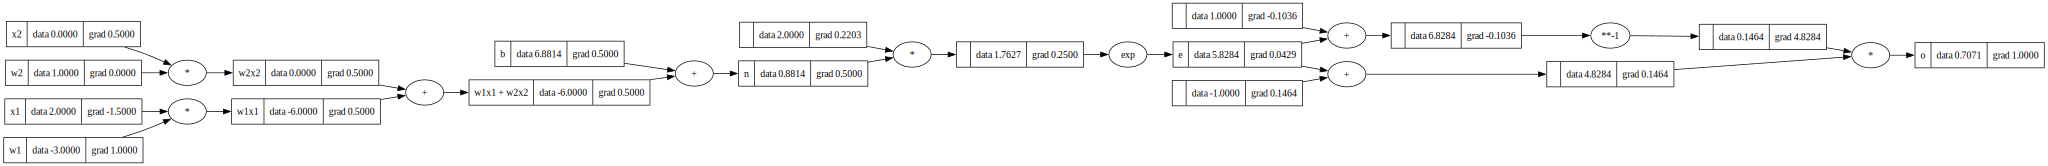

In [8]:
draw_dot(o)

# do the same thing in pytorch 

pytorch, tensor 

In [10]:
import torch
import random

In [11]:
# PyTorch tensors often default to torch.float32 (single-precision) for performance reasons, 
# especially on GPUs where single-precision computations are typically faster. 
# change to double just be identical to python float-point number(64-bit)

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
# .item takes one single tensor as element, takes that element out of the tensor
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Great question — in **your snippet**, “**one flat memory buffer**” is literally the tiny chunk of memory each tensor owns that holds its numbers.

* `x1, x2, w1, w2, b` are each **1-D tensors of length 1** (`shape=(1,)`, `dtype=float64`) on **CPU**.
  Each one has a flat buffer with **one 8-byte float**. That’s the “flat buffer.”
* `n = x1*w1 + x2*w2 + b` produces another **(1,)** tensor with its own 8-byte buffer.
* `o = tanh(n)` again is a **(1,)** tensor with its own 8-byte buffer.
* Autograd builds a **computation graph** linking these ops, but the **data** in each tensor still lives in its own flat buffer.

If you made them longer, say `x1 = torch.tensor([2., 4., 6.], dtype=torch.float64, requires_grad=True)`, then `x1`’s flat buffer would be **3 consecutive 8-byte numbers**. Indexing `[i]` just hops `i * stride * element_size` bytes from the base.

Want to *see* the layout? Run this on any of your tensors:

```python
t = x1  # or n, o, etc.
print("shape:", t.shape)
print("dtype:", t.dtype, "elem_size(bytes):", t.element_size())
print("strides (in elements):", t.stride())
print("storage_offset (elements):", t.storage_offset())
print("data_ptr (address):", t.data_ptr())
print("is_contiguous:", t.is_contiguous())
```

For your length-1 tensors you’ll see `shape=(1,)`, `stride=(1,)`, and a single address—the quintessential “one flat memory buffer.”

In [12]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [12]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

* Tensor ≈ N-dimensional array (like generalization of matrix)
* TPU = Tensor Processing Unit: designed to process tensors efficiently
* TensorFlow is named because it builds models using flows of tensors


# so tensors are stored as array of arrays of array ?

Short answer: **no** (not usually).
Most tensor libs (NumPy, PyTorch, TF) store an N-D tensor as:
* one flat memory buffer of numbers, plus
* metadata: shape, dtype, and strides (how far to jump in memory when an index increases along each axis), and sometimes a device and storage_offset.
So an element at index [i, j, k] lives at:

# address = base + i*stride0 + j*stride1 + k*stride2. 
(HAHAHA, vector plus result new vector in n-dimentional space)

go to the same spot with completely different physical ways
imagined space, 2 dimentions, one dot can be reached via thinking the space is:

array of an array, boxes, entire universe, go to vertical line, along i (y), then j(x), here (i, j) or (x, y)
default stride is 1, i*1 + j*1
base can be 0 or other 

vectors, each spot start with origin, point to a position in space. start (0,0), 
move along i with stride0, then j with stride1, reach point
i*stride0 + j*stride1
base can be 0 or other 


In [13]:
x1 = torch.Tensor([2.0]).double()  
x1

tensor([2.], dtype=torch.float64)

In [18]:
o
# o is an tensor object, it got backward function just as we implemented in micrograd

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [19]:
o.item()

0.7071066904050358

In [20]:
# can also use this func same to check o data value
o.data.item()

0.7071066904050358

In [21]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [22]:
x2.grad.item()

0.5000001283844369

In [ ]:
# neural networks are just a specific class of mathmatical expressions 
# building a two layer multi-layer perceptron 


In [14]:
# how python zip function work? 
# why after for print, the tuple print become empty? 

a = ("John", "Charles", "Mike")
b = ("Jenny", "Christy", "Monica")

x = zip(a, b)

for a, b in x:
	print(a, b)

John Jenny
Charles Christy
Mike Monica


In [12]:
print(x)

In [14]:
a = ("John", "Charles", "Mike")
b = ("Jenny", "Christy", "Monica")

x = zip(a, b)

#use the tuple() function to display a readable version of the result:
print(tuple(x))

(('John', 'Jenny'), ('Charles', 'Christy'), ('Mike', 'Monica'))


In [24]:
a = ["apple", "banana", "cherry"]
b = ("Jenny", "Christy", "Monica")

x = zip(a, b)
print (list(x))

[('apple', 'Jenny'), ('banana', 'Christy'), ('cherry', 'Monica')]


In [47]:
# an object can handle random numbers of inputs, with random number of weights

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  # [], n inputs, each generate a random weights
        self.b = Value(random.uniform(-1, 1))
       

    def __call__(self, x:list[int]):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # so cool, act = wi*xi + b, out = tanh(wi*xi+b)
        out = act.tanh()
        return out



class Layer:
    # out = tanh(wij*xij+bi)
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    # multi layer perceptron
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
x = [2.0, 3.0]
n = Neuron(2) 
# 2 dimential tensor 
n(x)

Value(data=-0.9756817064411358)

In [42]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.8482439429407015),
 Value(data=-0.9990284147740827),
 Value(data=-0.2526133342376671)]

In [49]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6697607511911408)

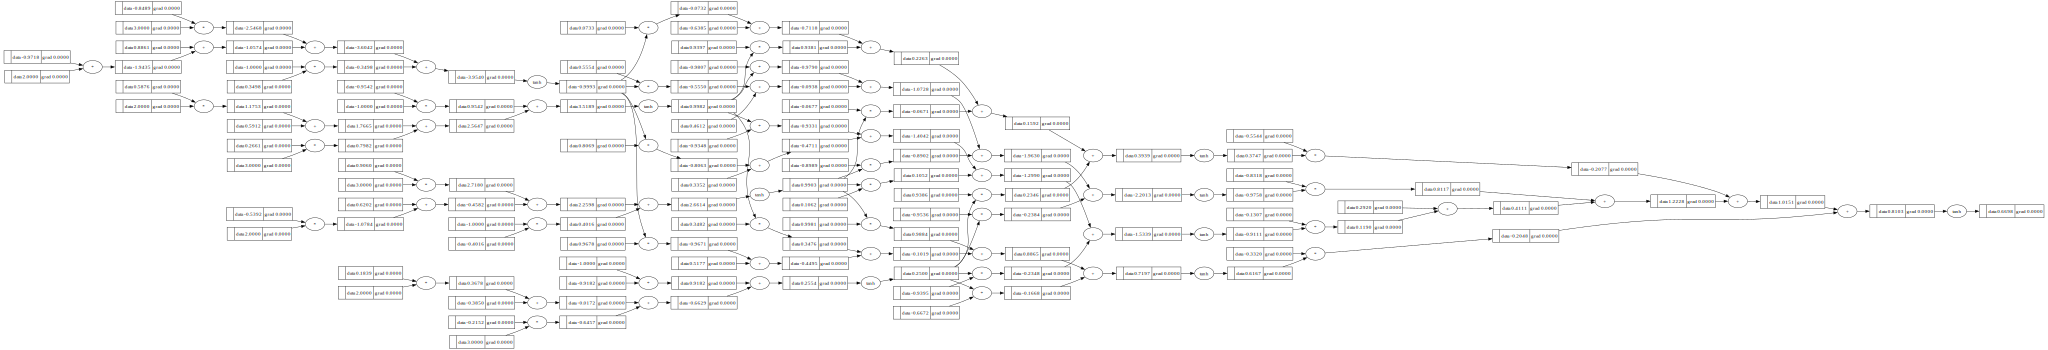

In [50]:
draw_dot(n(x))

In [29]:
a = 3
b = [1, 2, 3]

print([a]+ b)

[3, 1, 2, 3]


In [20]:
test = random.uniform(-1, 1)
test

-0.9944015296093687

In [33]:
# what is python generator expression? how it work, it looks so cool!!!

generator = (2*num for num in range(5))

for num in generator:
    print(num)

0
2
4
6
8


# In Python, to create iterators, we can use both regular functions and generators. 
https://www.geeksforgeeks.org/python/generator-expressions/

Generators are written just like a normal function but we use yield() instead of return() for returning a result. It is more powerful as a tool to implement iterators. It is easy and more convenient to implement because it offers the evaluation of elements on demand. Unlike regular functions which on encountering a return statement terminates entirely, generators use a yield statement in which the state of the function is saved from the last call and can be picked up or resumed the next time we call a generator function. Another great advantage of the generator over a list is that it takes much less memory. 

In addition to that, two more functions _next_() and _iter_() make the generator function more compact and reliable. Example : 

In [40]:
def generator(): 
    t = 1
    print ('First result is ',t) 
    yield t 

    t += 1
    print ('Second result is ',t) 
    yield t 

    t += 1
    print('Third result is ',t) 
    yield t 

call = generator() 
next(call) 
next(call) 
next(call)

First result is  1
Second result is  2
Third result is  3


3

In [ ]:
# a layer, a list of neurons 

